# Heart Failure Prediction 

This Dataset is a combination of 5 independent datasets. They had 11 features in common, which are displayed in this dataset.
We will use the data from 


Acknowledgements

    1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor:
David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

Used dataset from: https://www.kaggle.com/fedesoriano/heart-failure-prediction

 # Used Libraries and loading data into data frame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Attributes of the data:
    1. Age: age of the patient (years)
    2. Sex: sex of the patient (M: Male, F: Female)
    3. ChestPainType: chest pain type (TA: Typ. Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
    4. RestingBP: resting blood pressure (mm Hg)
    5. Cholesterol: serum cholesterol (mm/dl) (Normal if < 200)
    6. FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
    7. RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality, LVH: showing probable  or definite left ventricular hypertrophy by Estes' criteria)
    8. MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)
    9. ExerciseAngina: exercise-induced angina (Y: Yes, N: No)
    10. Oldpeak: oldpeak = ST (Numeric value measured in depression)
    11. ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
    12. HeartDisease: output class (1: heart disease, 0: Normal)
    

# Checking for missing values and looking at the data types

In [2]:
print(df.isnull().sum().sum()) #Finding missing values
print(df.dtypes)

0
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


It seems like we have no missing data and features are either numeric or objects.

# Correlation of the data

Here we will plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable "HeartDisease".
The correlation coefficient has values between -1 and 1.
A value of 0 indicates that there is no association between the two variables. A value greater than 0 indicates a positive association; that is, as the value of one variable increases, so does the value of the other variable. A value less than 0 indicates a negative association; that is, as the value of one variable increases, the value of the other variable decreases.

Age                 int64
Sex                  int8
ChestPainType        int8
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG           int8
MaxHR               int64
ExerciseAngina       int8
Oldpeak           float64
ST_Slope             int8
HeartDisease        int64
dtype: object


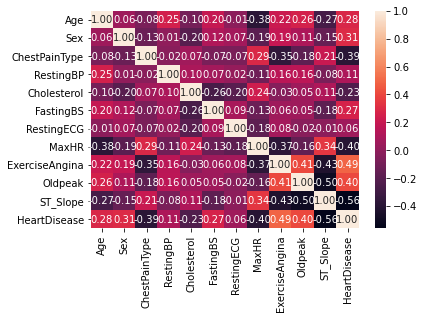

In [3]:
#Using Pearson Correlation
df['Sex'] =df['Sex'].astype('category').cat.codes # [F,M] --> [0,1]

#Here we convert our object arguments into an int type
df['ExerciseAngina'] =df['ExerciseAngina'].astype('category').cat.codes # [N,Y] --> [0,1]
df['RestingECG'] =df['RestingECG'].astype('category').cat.codes #[LVH,Normal,ST] --> [0,1,2]
df['ChestPainType'] =df['ChestPainType'].astype('category').cat.codes # [ASY,ATA,NAP,TA] -->[0,1,2,3]
df['ST_Slope'] =df['ST_Slope'].astype('category').cat.codes # [ASY,ATA,NAP,TA] -->[0,1,2,3]
print(df.dtypes)
sns.heatmap(df.corr(), annot=True, fmt=".2f")

 Since we are focused on the outcome of the feature "HeartDisease", we will look at the last row.
 The following features corralte the most: "MaxHR", "ExerciseAngina", "Oldpeak" and "ST_Slope".
 Hence we will drop all other features.
 However before that we need to see wether our chosen features correlate with each other. If they do we will
 only need one of them.

In [4]:
print(df[["MaxHR","ExerciseAngina"]].corr())
print(df[["MaxHR","Oldpeak"]].corr())
print(df[["MaxHR","ST_Slope"]].corr())
print(df[["ExerciseAngina", "Oldpeak"]].corr())
print(df[["ExerciseAngina", "ST_Slope"]].corr())
print(df[["Oldpeak", "ST_Slope"]].corr())

                   MaxHR  ExerciseAngina
MaxHR           1.000000       -0.370425
ExerciseAngina -0.370425        1.000000
            MaxHR   Oldpeak
MaxHR    1.000000 -0.160691
Oldpeak -0.160691  1.000000
             MaxHR  ST_Slope
MaxHR     1.000000  0.343419
ST_Slope  0.343419  1.000000
                ExerciseAngina   Oldpeak
ExerciseAngina        1.000000  0.408752
Oldpeak               0.408752  1.000000
                ExerciseAngina  ST_Slope
ExerciseAngina        1.000000 -0.428706
ST_Slope             -0.428706  1.000000
           Oldpeak  ST_Slope
Oldpeak   1.000000 -0.501921
ST_Slope -0.501921  1.000000


Since "ExerciseAngina" adn "ST_Slope" have a high corraltion with "MaxHR" and "Oldpeak" we will drop them.

In [5]:
df_new = df[["MaxHR", "Oldpeak", "HeartDisease"]]
df_new.head()

,MaxHR,Oldpeak,HeartDisease
0,172,0.0,0
1,156,1.0,1
2,98,0.0,0
3,108,1.5,1
4,122,0.0,0


With those two features we will try to predict an heartdisease.

# Prepare a Training Dataset

In [6]:
X = df[["MaxHR", "Oldpeak"]]#Feature Matrix
y = df["HeartDisease"] #Target Variable

# define model
model = LogisticRegression(solver='lbfgs')
# fit model
model.fit(X, y)
# make predictions
yhat = model.predict(X)
# evaluate predictions
acc = accuracy_score(y, yhat)
print(acc)

0.7429193899782135


# Making Predictions with new input

In [7]:
new_input = [[70, 1]]
new_output = model.predict(new_input)
#Prediction
print("Output:", new_output)

Output: [1]


It would also be useful to know how high the probability for the outcome is.

In [8]:
log_prob = model.predict_log_proba(new_input)
proba = model.predict_proba(new_input)

print("Probability:", proba) #[No Heart disease, Heart disease]

Probability: [[0.05949208 0.94050792]]


This gives us a probability of 6 % for no heart disease and of 94 % a heart disease.


Credits to Jason Brownlee for his fitting model:
https://machinelearningmastery.com/how-to-connect-model-input-data-with-predictions-for-machine-learning/

# Using the prediction model for our three questions

1) What is the probability of a heart disease for men and women based on their age?<br>
2) Can the data from a smart watch (which records the heart ratio and the blood pressure) increase
   the accuracy of the model from question 1?<br>
3) Which other of the features complements the already used features best?

# 1) Accuracy of the prediction based on "Sex" and "Age"

In [9]:
age_sex = df[["Age", "Sex"]]#Feature Matrix

model = LogisticRegression(solver='lbfgs')
model.fit(age_sex, y)
yhat = model.predict(age_sex)
acc2 = accuracy_score(y, yhat)
print("Accuracy:",acc2)

Accuracy: 0.6895424836601307


Now we are plotting the probability over the age for men and women.

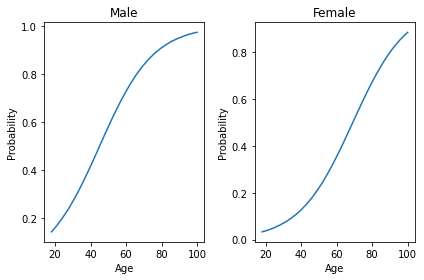

In [10]:
age = 18 #starting age
Listx = []
Listy = []
Listz = []
while age <= 100:
    Listx.append(age)
    male_input = [[age, 1]]
    female_input = [[age, 0]]
    
    male_output = model.predict(male_input)
    log_prob = model.predict_log_proba(male_input)
    proba = model.predict_proba(male_input)
    
    female_output = model.predict(female_input)
    log_prob2 = model.predict_log_proba(female_input)
    proba2 = model.predict_proba(female_input)
    
    Listy.append(round(proba[0,1],3))
    Listz.append(round(proba2[0,1],3))
    age = age + 1

plt.subplot(1,2,1)
plt.plot(Listx, Listy)
plt.title("Male")
plt.xlabel("Age")
plt.ylabel("Probability")

plt.subplot(1,2,2)
plt.plot(Listx, Listz)
plt.title("Female")
plt.xlabel("Age")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# 2) From the smart watch we acquire "MaxHR" and "RestingBP"

From the heatmap before we can see the correlation of "MaxHR", "RestingBP" and "HeartDiesease".
Between "MaxHR" and "HearDisease" we have a higher correlation than between "RestingBP" and "HeartDiesease".
This gives us a first hint, however we will still compare the accuracies.

In [11]:
hr_ = df[["Age", "Sex","MaxHR"]]#Feature Matrix 1
bp_ = df[["Age", "Sex", "RestingBP"]]#Feature Matrix 2
hr_bp = df[["Age", "Sex","MaxHR", "RestingBP"]]#Feature Matrix 3


model = LogisticRegression(solver='lbfgs')
model.fit(hr_, y)
yhat = model.predict(hr_)
acc3 = accuracy_score(y, yhat)
print("Accuracy(MaxHR):",acc3)
model.fit(bp_, y)
yhat = model.predict(bp_)
acc4 = accuracy_score(y, yhat)
print("Accuracy(RestingBP):",acc4)
model.fit(hr_bp, y)
yhat = model.predict(hr_bp)
acc5 = accuracy_score(y, yhat)
print("Accuracy(MaxHR and RestingBP):",acc5)


Accuracy(MaxHR): 0.7124183006535948
Accuracy(RestingBP): 0.6884531590413944
Accuracy(MaxHR and RestingBP): 0.7091503267973857


So the heart ratio increases our accuracy while the blood pressure is doing the opposite.

# 3) Increasing the accuracy with a parameter which won't  be acquired with a standard smart watch

"ST_Slope" has the highest correlation with "HeartDisease" with a value of -0,56, so we will go with it, even so a smart watch can't make that kind of statement yet.

In [12]:
st_slope = df[["Age", "Sex","MaxHR","ST_Slope"]]#Feature Matrix

model = LogisticRegression(solver='lbfgs')
model.fit(st_slope, y)
yhat = model.predict(st_slope)
acc6 = accuracy_score(y, yhat)
print("Accuracy:",acc6)

Accuracy: 0.8169934640522876


That feature increased our accuracy by 10.5%.

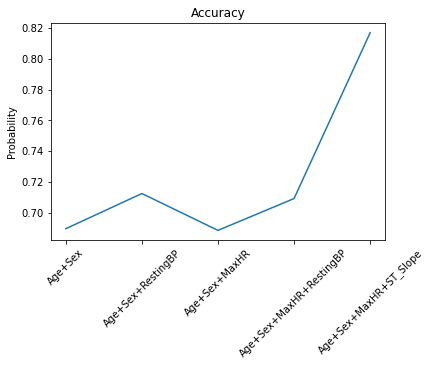

In [13]:
x = ["Age+Sex", "Age+Sex+RestingBP","Age+Sex+MaxHR","Age+Sex+MaxHR+RestingBP","Age+Sex+MaxHR+ST_Slope",]
y = [acc2,acc3,acc4,acc5,acc6]
plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.title("Accuracy")
plt.plot(x,y)

So at the start we had a model which consisted of the features "Age" and "Sex". With an accuracy of 69 % we could pedict a heart disease (based on the dataset). With athe data acquired by a smart watch we increased it by a mere 2 % since those features didn't correlate well with the feature "HeartDisease", which had the highest correlation with "ST_Slope". With it the accuracy rose by 10%. So if a smart watch company were interested in predicting a heart disease and could invest in one of our features, "ST_Slope" would be best.